In [1]:
import numpy as np
import os
from keras import backend as K
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
import tensorflow as tf

from tensorflow.keras.datasets import cifar10

Using TensorFlow backend.


In [2]:
def id_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    X_shortcut = X
   
    X = Conv2D(filters=filters, kernel_size=(1, 1), strides=(1, 1), padding='same', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)


    X = Conv2D(filters=filters, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [3]:
def conv_block(X, f, filters, stage, block, s=2):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    X_shortcut = X
    
    X = Conv2D(filters=filters, kernel_size=(1, 1), strides=(s, s), padding='same', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters=filters, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    
    X_shortcut = Conv2D(filters=filters, kernel_size=(1, 1), strides=(s, s), padding='same', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [4]:
def ResNet18(input_shape=(28, 28, 1)):

    # Input 
    X_input = Input(input_shape)
    
    #X = ZeroPadding2D((3, 3))(X_input)

    # Conv1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0), padding="same")(X_input)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2), padding="same")(X)

    # Layer 1
    X = id_block(X, 3, 64, stage=2, block='a')
    X = id_block(X, 3, 64, stage=2, block='b')

    # Layer 2
    X = conv_block(X, f=3, filters=128, stage=3, block='a', s=2)
    X = id_block(X, 3, 128, stage=3, block='b')

    # Layer 3
    X = conv_block(X, f=3, filters=256, stage=4, block='a', s=2)
    X = id_block(X, 3, 256, stage=4, block='b')

    # Layer 4
    X = X = conv_block(X, f=3, filters=512, stage=5, block='a', s=2)
    X = id_block(X, 3, 512, stage=5, block='b')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet18')

    return model

In [5]:
(train_x, train_y), (test_x, test_y) = cifar10.load_data()

# normalize to range 0-1
train_x = train_x / 255.0
test_x = test_x / 255.0

val_x = train_x[:5000]
val_y = train_y[:5000]

In [6]:
Input18 = ResNet18(train_x[0].shape)

In [7]:
headModel18 = Input18.output
# Flatten
headModel18 = Flatten()(headModel18)
# FC
headModel18 = Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel18)
headModel18 = Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel18)
# Output
headModel18 = Dense(10,activation='softmax', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel18)

In [8]:
model18 = Model(inputs=Input18.input, outputs=headModel18)

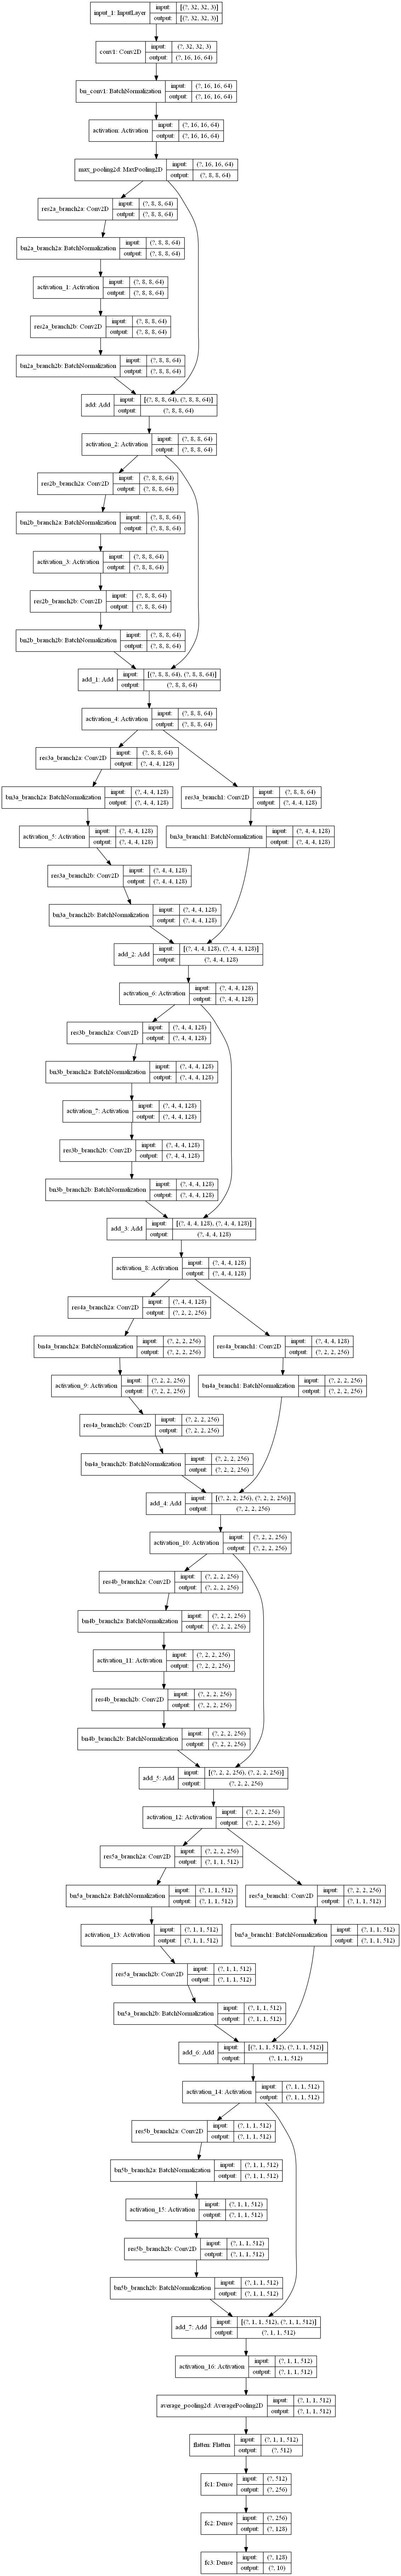

In [9]:
plot_model(model18, show_shapes=True)

In [12]:
model18.compile(optimizer='adam', loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
#model18.summary()
len(model18.layers)

72

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', verbose=1)
list_cb = [es]

In [87]:
start = time()
model.fit( train_x , train_y , epochs=50, batch_size=1024, validation_split=0.2, callbacks=list_cb)
training_time = time()-start

Train on 50000 samples, validate on 5000 samples
Epoch 1/5
50000/50000 [==============================] - 733s 15ms/sample - loss: 1.0538 - accuracy: 0.6378 - val_loss: 1.2395 - val_accuracy: 0.5846
Epoch 2/5
50000/50000 [==============================] - 675s 14ms/sample - loss: 0.8721 - accuracy: 0.6992 - val_loss: 0.9521 - val_accuracy: 0.6836
Epoch 3/5
50000/50000 [==============================] - 658s 13ms/sample - loss: 0.7594 - accuracy: 0.7406 - val_loss: 2.4693 - val_accuracy: 0.3980
Epoch 4/5
50000/50000 [==============================] - 660s 13ms/sample - loss: 0.6722 - accuracy: 0.7698 - val_loss: 0.7006 - val_accuracy: 0.7558
Epoch 5/5
50000/50000 [==============================] - 397s 8ms/sample - loss: 0.5935 - accuracy: 0.7962 - val_loss: 0.7114 - val_accuracy: 0.7566


In [88]:
model18.evaluate(test_x, test_y)

10000/10000 [==============================] - 6s 567us/sample - loss: 0.9940 - accuracy: 0.6689


[0.9939967523574829, 0.6689]

In [89]:
model18.evaluate(train_x, train_y)

50000/50000 [==============================] - 29s 589us/sample - loss: 0.7161 - accuracy: 0.7516


[0.7161020271396636, 0.75164]

In [1]:
training_time

NameError: name 'training_time' is not defined